# transfer call ngram anaylsis support agent 26/07/2021

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
import multiprocessing

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

import gensim
import spacy 
import logging
import warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer

import pickle
import spacy
import ast

import pyLDAvis
import pyLDAvis.gensim  
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)



%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/conda/envs/lda_bert/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/lda_bert/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/lda_bert/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing 

In [2]:
# genral stop words
stop_words = stopwords.words('english')

# extened stopwords
file = open(r"/home/jupyter/Amwell_gpu/utils/extended_stopwords.txt", "r")
stop_words.extend([line.strip() for line in file.readlines()])
file.close()

# custom amwell stopwrds
file = open(r"/home/jupyter/Amwell_gpu/utils/custom_amwell_stopwords.txt", "r") 
stop_words.extend([line.strip() for line in file.readlines()])
file.close()

# custom amwell insurance stopwrds
file = open(r"/home/jupyter/Amwell_gpu/utils/insurance_stopwords.txt", "r") 
stop_words.extend([line.strip() for line in file.readlines()])
file.close()

# convert all to lovwer case
stop_words = [ i.lower() for i in stop_words]

# contractions 
file = open(r"/home/jupyter/Amwell_gpu/utils/contractions.txt", "r")
contractions = ast.literal_eval(file.read())
file.close()

print(len(stop_words))

1736


In [3]:
# df_session =pd.read_csv(r"/home/jupyter/Amwell_gpu/data/data_sup_con.csv")
# df_calls = pd.read_csv(r"/home/jupyter/Amwell_gpu/data/data_ingestion_output_20K.csv")

# print(df_session.shape)
# print(df_calls.shape)

# df_merge = pd.merge(df_calls, df_session, on="Session_id")
# # df_merge.head()

# df_con = df_merge[df_merge["queue_name"]=="Amwell Concierge"]
# df_con = df_con.sort_values(by=["Session_id","Sequence"]).reset_index(drop=True)
# print(df_con.shape)
# df_con.head()

In [4]:
from google.cloud import bigquery

def read_cluster_data(query,project_id,data_type="STRING",**kwargs):
    """
    reading query data

    :type query: String
    :param query: Sql query for extracting data from big query

    :type project_id: String
    :param project_id: project id associated with big query
    """
    query_parameters=[]
    for key, value in kwargs.items():
        query_parameters.append(bigquery.ScalarQueryParameter(key, data_type, value))   
    client = bigquery.Client()
    job_config = bigquery.QueryJobConfig(query_parameters=query_parameters)
    df = client.query(query, job_config=job_config, project=project_id).to_dataframe()
    return df




qu = """select *
from fivestar-ccai-recordings.fivestar_ccai_recordings.call_sentiment_support_8jul_offshore
where session_id like '%Support%'
and (lower(redacted_transcript) like '%connect you%'
or lower(redacted_transcript) like '%get you transferred%'
or lower(redacted_transcript) like '%get you over%'
or lower(redacted_transcript) like '%transfer you over%'
or lower(redacted_transcript) like '%send you%'
or lower(redacted_transcript) like '%going to transfer%'
or lower(redacted_transcript) like '%need to transfer%'
or lower(redacted_transcript) like '%get you to%'
or lower(redacted_transcript) like '%transfer you to%')"""

df_support = read_cluster_data(query =qu ,project_id='fivestar-ccai-recordings')
print("Shape : ", df_support.shape)
df_support.head()

Shape :  (5697, 7)


,Session_id,redacted_transcript,sentiment_score,magnitude,speaker,start_timestamp_usec,sequence
0,AmWell Support.1084.037E839.03-14-2021-162135,Thank you for calling clear. Call support cen...,0.0,5.8,Agent,1000000,149764
1,AmWell Support.207.0369CBF.03-14-2021-101947,"Thank you for calling American. Well, support ...",0.0,5.3,Agent,1000000,152321
2,AmWell Support.284.03K0167.03-15-2021-192355,"Thank you for calling American. Well, support...",0.0,12.9,Agent,1000000,153934
3,AmWell Support.38.03MV3E3.03-16-2021-104024,"Thank you for calling American. Well, support ...",0.0,3.5,Agent,1000000,154851
4,AmWell Support.430.03PPT41.03-16-2021-124453,"Thank you for calling American. Well, support ...",0.0,10.5,Agent,1000000,155571


In [5]:
# chek how many duplicates row 
# duplicates_transfer_recored = df_support[df_support.duplicated(["Session_id", "redacted_transcript"])].reset_index(drop=True)
duplicates_transfer_recored2 = df_support[df_support.duplicated(["Session_id", "start_timestamp_usec"])].reset_index(drop=True)
# duplicates_transfer_recored2.to_gbq("amwell_ccai_fivestar_dev_us_ds.transfercall_duplicates",
#                                     'fivestar-ccai-recordings',
#                                     chunksize= 10000,
#                                     if_exists='replace'
#                                     )
# print(duplicates_transfer_recored.shape)
print(duplicates_transfer_recored2.shape)

(241, 7)


In [6]:
duplicates_transfer_recored2.tail()

,Session_id,redacted_transcript,sentiment_score,magnitude,speaker,start_timestamp_usec,sequence
236,AmWell Support.903.02QZT33.03-11-2021-155331,I'll send you an email. So with that informati...,-0.1,0.5,Agent,77000000,369472
237,AmWell Support.1087.03J3HS.03-15-2021-172318,Yeah. You just click on the one that you need ...,0.5,1.6,Agent,81000000,237866
238,AmWell Support.1179.02RZR60.03-11-2021-173251,"button. Yes. So when I can send you, Okay.",0.0,0.8,Agent,83000000,242769
239,AmWell Support.1310.02ZFT82.03-12-2021-145035,want to let you know. So we've got I'm going t...,0.0,3.7,Agent,85000000,248787
240,AmWell Support.2349.02Q6Q6H.03-11-2021-152118,"okay. All right, I'm going to send. You don't ...",-0.1,1.5,Agent,117000000,278103


In [7]:

df_support[df_support["Session_id"] == "AmWell Support.346.03B8W2Q.03-15-2021-100042"]

,Session_id,redacted_transcript,sentiment_score,magnitude,speaker,start_timestamp_usec,sequence
241,AmWell Support.346.03B8W2Q.03-15-2021-100042,"For calling American. Well, support on a reco...",0.1,6.4,Agent,1000000,154525
305,AmWell Support.346.03B8W2Q.03-15-2021-100042,"For calling American. Well, support on a reco...",0.1,6.4,Agent,1000000,299381


In [8]:
df_support[df_support["Session_id"] == "AmWell Support.207.0369CBF.03-14-2021-101947"] # eg for duplicates recored 

,Session_id,redacted_transcript,sentiment_score,magnitude,speaker,start_timestamp_usec,sequence
1,AmWell Support.207.0369CBF.03-14-2021-101947,"Thank you for calling American. Well, support ...",0.0,5.3,Agent,1000000,152321
123,AmWell Support.207.0369CBF.03-14-2021-101947,"Thank you for calling American. Well, support ...",0.0,5.3,Agent,1000000,271763
4610,AmWell Support.207.0369CBF.03-14-2021-101947,"Okay, so yes, I don't show anything in here ye...",0.0,2.2,User,16000000,152336
4613,AmWell Support.207.0369CBF.03-14-2021-101947,"familiar Okay, so yes, I don't show anything i...",0.0,2.1,User,16000000,271778
4847,AmWell Support.207.0369CBF.03-14-2021-101947,transfer you over. I do want to thank you for ...,0.3,1.9,User,20000000,152340
4849,AmWell Support.207.0369CBF.03-14-2021-101947,transfer you over. I do want to thank you for ...,0.3,1.9,User,20000000,271782


In [9]:
df_sup  = df_support.drop_duplicates(subset=["Session_id", "start_timestamp_usec"], keep= "last").reset_index(drop=True)
print("After droping duplicates : ", df_sup.shape)

After droping duplicates :  (5456, 7)


In [10]:
df_sup[df_sup["Session_id"] == "AmWell Support.207.0369CBF.03-14-2021-101947"] # verfify the duplicates droped correctly

,Session_id,redacted_transcript,sentiment_score,magnitude,speaker,start_timestamp_usec,sequence
115,AmWell Support.207.0369CBF.03-14-2021-101947,"Thank you for calling American. Well, support ...",0.0,5.3,Agent,1000000,271763
4415,AmWell Support.207.0369CBF.03-14-2021-101947,"familiar Okay, so yes, I don't show anything i...",0.0,2.1,User,16000000,271778
4644,AmWell Support.207.0369CBF.03-14-2021-101947,transfer you over. I do want to thank you for ...,0.3,1.9,User,20000000,271782


In [11]:
# df_con_cus = df_con[df_con["Role"]=="CUSTOMER"]
# df_con_ag = df_con[df_con["Role"]=="AGENT"]

# print("total text for customer: ", df_con_cus.shape)
# print("total text for agent: ", df_con_ag.shape)

# # get second utter by grouping the session id
# cus = df_con_cus.groupby("Session_id").nth(1).reset_index()
# ag = df_con_ag.groupby("Session_id").nth(1).reset_index()

# print("after grouping customer shape: ", cus.shape)
# print("after grouping agent shape: ", ag.shape)

In [12]:
# unique for session id
print(df_sup["Session_id"].nunique())
# print(ag["Session_id"].nunique())

4464


In [13]:
# cus.to_csv("second_conv_con_customer.csv",index=False)
# ag.to_csv("second_conv_con_agent.csv",index=False)

# Text Preprocessing

In [14]:
# # Convert to list
# text_customer = cus.Text.values.tolist()
# text_agent = ag.Text.values.tolist()

# print("Total text for customer: ", len(text_customer))
# print("Total text for agent: ", len(text_agent))


text = df_sup.redacted_transcript.values.tolist()
print("Total text for agent: ", len(text))

Total text for agent:  5456


In [15]:

def clean_text(text):
    # remove numbers spaces

    text_step1 = []
    with tqdm(total=len(text)) as pbar:
        for i in range(0, len(text)):
            review = re.sub("\d+", "", str(text[i]))
            text_step1.append(review)
            pbar.update(1)
    text = text_step1  # re-assigning
    del text_step1

    # remove junks

    text_step2 = []
    with tqdm(total=len(text)) as pbar:
        for i in range(0, len(text)):
            review = re.sub(r"\W", " ", str(text[i]))
            review = review.lower()
            review = re.sub(r"\s+[a-z]\s+", " ", review)
            review = re.sub(r"^[a-z]\s+", " ", review)
            review = re.sub(r"\d+", " ", review)
            review = re.sub(r"\s+", " ", review)
            text_step2.append(review)
            pbar.update(1)

    text = text_step2  # re-assigning
    del text_step2

    # preprocess 

    text_step3 = []

    with tqdm(total=len(text)) as pbar:
        for i in text:
            review = gensim.utils.simple_preprocess(str(i), deacc=True)
            text_step3.append(review)
            pbar.update(1)

    text = text_step3
    del text_step3

    # remove stopwords

    text_step4 = []

    with tqdm(total=len(text)) as pbar:
        for i in text:
            ii = []
            for word in i:
                if word not in stop_words:
                    ii.append(word)
            text_step4.append(ii)
            pbar.update(1)

    text = text_step4
    del text_step4

    # lemetize 

    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    nlp.max_length = (
        3000000  # increasing text length to 3000000 from default of 1000000
    )
    allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"]

    text_step7 = []

    with tqdm(total=len(text)) as pbar:
        for i in text:
            doc = nlp(" ".join(i))
            text_step7.append(
                [token.lemma_ for token in doc if token.pos_ in allowed_postags]
            )
            pbar.update(1)

    text = text_step7
    del text_step7

    # one more time stop words removed 

    text_step8 = []

    with tqdm(total=len(text)) as pbar:
        for i in text:
            ii = []
            for word in i:
                if word not in stop_words:
                    ii.append(word)
            text_step8.append(ii)
            pbar.update(1)

    text = text_step8
    del text_step8
    print("[INFO] Text len: ", len(text))
    print("[INFO] Text cleaning Done...")
    
    return text



In [16]:
%%time

clean_text = clean_text(text)

100%|██████████| 5456/5456 [00:00<00:00, 5559.18it/s]

[INFO] Text len:  5456
[INFO] Text cleaning Done...
CPU times: user 17 s, sys: 97.3 ms, total: 17.1 s
Wall time: 17.8 s


In [17]:
# %%time

# clean_text_agent = clean_text(text_agent)

### check sample text

In [18]:
text[74]

"Thank you for calling American. Well, support. This is #####. Speaking, we are on a recorded line, how can I help you? My name is #####. #####, I'm trying. I'm trying to # good Telehealth, Psychiatry service for my grandmother for a consultation. I just had a few questions, if that's all right, get you over to a product specialist is a billing question or is it, uh, account? I mean, is that like a the app question or the website question medical-related concerning to, how do I access previous medical records current medications and she's on that sort of thing if that needs to be faxed over from the primary care office and whatnot. Okay, let me get you over to an account specialist and they can probably help you out with that. You guys have any friends or LPNs on staff answer, questions that. You have to sign up to talk to a nurse or a doctor, you have to sign up on an app or the website in order to talk to a doctor or nurse. Okay. Thank you. So I'll put you over to an account speciali

In [19]:
" ".join(clean_text[74])

'support record telehealth psychiatry grandmother consultation question product specialist billing question account app question website question access previous record current medication fax primary office whatnot account specialist friend lpns staff answer question sign nurse doctor sign app website order doctor nurse account specialist'

# create corpus

In [20]:
# create dict of 

def create_corpus(text, df):
    id2word = corpora.Dictionary(text)
    corpus = []
    with tqdm(total=len(text)) as pbar:
        for i in text:
            d = id2word.doc2bow(i)
            corpus.append(d)
            pbar.update(1)

    # add clean text to the og dataframe

    text_join = []

    with tqdm(total=len(text)) as pbar:
        for i in text:
            word = " ".join(i)
            text_join.append(word)
            pbar.update(1)

    df["clean_text"] = text_join
    print("shape: ", df.shape)
    print("[INFO] corpus created...")
    return df, corpus

In [21]:
%%time

df_sup, corpus = create_corpus(clean_text, df_sup)
# ag, agent_corpus = create_corpus(clean_text_agent, ag)

100%|██████████| 5456/5456 [00:00<00:00, 1266275.05it/s]

shape:  (5456, 8)
[INFO] corpus created...
CPU times: user 114 ms, sys: 76 µs, total: 114 ms
Wall time: 112 ms


In [22]:
df_sup.head()

,Session_id,redacted_transcript,sentiment_score,magnitude,speaker,start_timestamp_usec,sequence,clean_text
0,AmWell Support.284.03K0167.03-15-2021-192355,"Thank you for calling American. Well, support...",0.0,12.9,Agent,1000000,153934,support record appointment information prescri...
1,AmWell Support.52.0366KE7.03-14-2021-095426,"Thank you for calling American, will support o...",0.0,2.4,Agent,1000000,156575,support record confirm cover insurance informa...
2,AmWell Support.69.03MTX4R.03-16-2021-104044,"Thank you for calling American. Well, support...",0.0,5.7,Agent,1000000,158552,support record login enrol system apologize in...
3,AmWell Support.1031.01KMX5N.03-08-2021-023059,"Thank you for calling American. Well, support ...",0.0,6.5,Agent,1000000,162458,support record transfer technical support agen...
4,AmWell Support.104.00HDH38.01-13-2021-203809,Thank you for calling American Wild support. W...,0.0,12.9,Agent,1000000,162726,wild support record tonight copy receipt payme...


In [23]:
    
def empty_doc(df):
    empty_doc = 0
    empty_idx = []
    for idx, doc in enumerate(df["clean_text"]):
        if len(doc) == 0:
            empty_doc += 1
            empty_idx.append(idx)

    print("All document: ", df.shape[0])        
    print("Total Empty Documents: ", empty_doc)
    print("Final Document: ", df.shape[0] - empty_doc)
    print("loss Percent: ", round(empty_doc/df.shape[0],2))

In [24]:
empty_doc(df_sup)

All document:  5456
Total Empty Documents:  112
Final Document:  5344
loss Percent:  0.02


In [25]:
# write clean dataframe for future refrencess added clean text columns
# cus.to_csv("second_conv_con_customer.csv",index=False)
# ag.to_csv("second_conv_con_agent.csv",index=False)

# Top Bigrams

In [26]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
topic_num = 0
stopwords = set(STOPWORDS)

In [27]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [
        (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [28]:
# for customer
bigram_words = get_top_n_bigram(df_sup["clean_text"], 60)
bigram_df = pd.DataFrame(bigram_words, columns=["Text", "count"])

# for agent
# bigram_words_ag = get_top_n_bigram(ag["clean_text"], 60)
# bigram_df_ag = pd.DataFrame(bigram_words_ag, columns=["Text", "count"])

In [29]:
bigrcus = (
        bigram_df.groupby("Text")
        .sum()["count"]
        .sort_values(ascending=False)
        .iplot(
            kind="bar",
            yTitle="Count",
            linecolor="black",
            title="Top 60 bigrams For Transfer",
            asFigure=True # plotly obj needs to be returned for streamlit to interpret
            )
        )
# bigrag = (
#         bigram_df_ag.groupby("Text")
#         .sum()["count"]
#         .sort_values(ascending=False)
#         .iplot(
#             kind="bar",
#             yTitle="Count",
#             linecolor="black",
#             title="Top 60 bigrams For Agent",
#             asFigure=True # plotly obj needs to be returned for streamlit to interpret
#             )
#         )

In [31]:
bigram_df.head(60)

,Text,count
0,account specialist,1334
1,support record,652
2,support team,650
3,transfer account,554
4,reset password,419
5,transfer support,413
6,password reset,382
7,specialist assist,372
8,transfer prescription,135
9,connect support,133


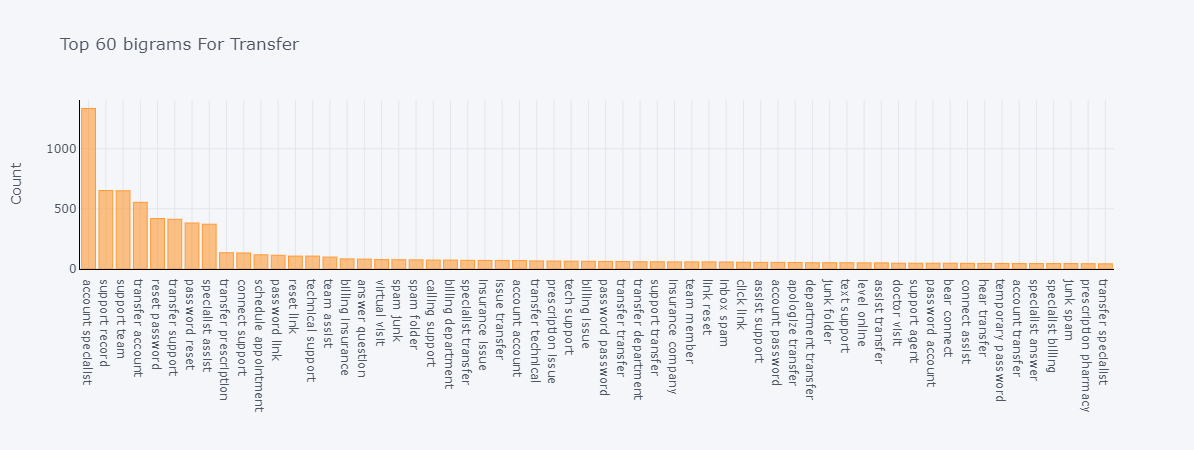

In [32]:
bigrcus

In [33]:
# method 1: convert to dict 
bigr_data = dict(zip(bigram_df['Text'].tolist(), bigram_df['count'].tolist()))
# freq_data # {'call': 62817,'appointment': 35219....}
# bigr_data_ag = dict(zip(bigram_df_ag['Text'].tolist(), bigram_df_ag['count'].tolist()))

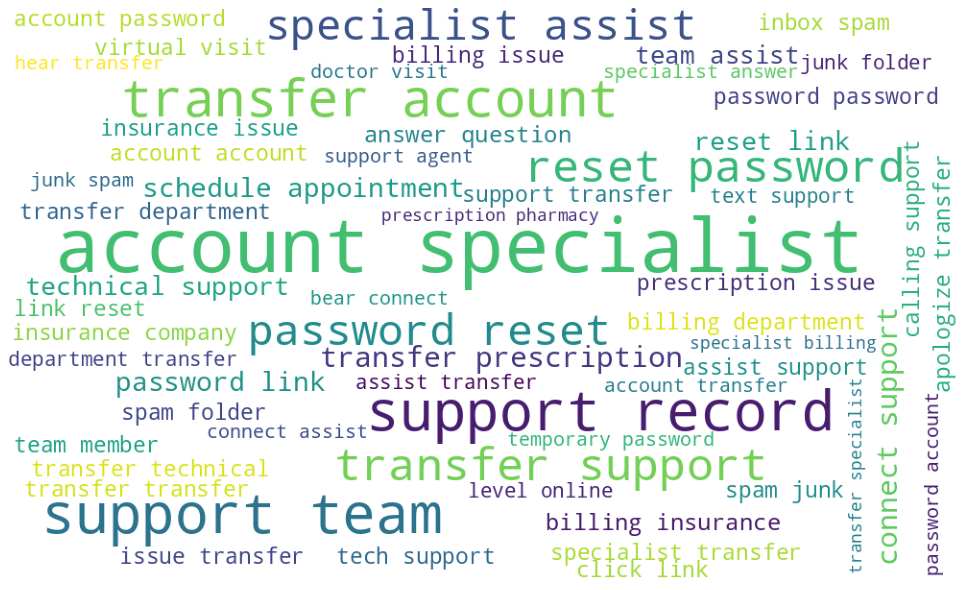

In [34]:
wordcloud = WordCloud(
                width=1000,
                height=600,
                background_color="white",
                stopwords=stopwords,
                min_font_size=10,
                collocations=False
            ).generate_from_frequencies(bigr_data)

# plot the WordCloud image
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### TOP Traigrams

In [35]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
   
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [
        (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [36]:
# customer
trigram_words = get_top_n_trigram(df_sup["clean_text"], 60)
trigram_df = pd.DataFrame(trigram_words, columns=["Text", "count"])

# customer
# trigram_words_ag = get_top_n_trigram(ag["clean_text"], 60)
# trigram_df_ag = pd.DataFrame(trigram_words_ag, columns=["Text", "count"])

In [37]:
trigrcus = (
        trigram_df.groupby("Text")
        .sum()["count"]
        .sort_values(ascending=False)
        .iplot(
            kind="bar",
            yTitle="Count",
            linecolor="black",
            title="Top 60 Trigram For Transfer",
            asFigure=True # plotly obj needs to be returned for streamlit to interpret
            )
        )
# trigrag = (
#         trigram_df_ag.groupby("Text")
#         .sum()["count"]
#         .sort_values(ascending=False)
#         .iplot(
#             kind="bar",
#             yTitle="Count",
#             linecolor="black",
#             title="Top 60 Traigram For Agent",
#             asFigure=True # plotly obj needs to be returned for streamlit to interpret
#             )
#         )

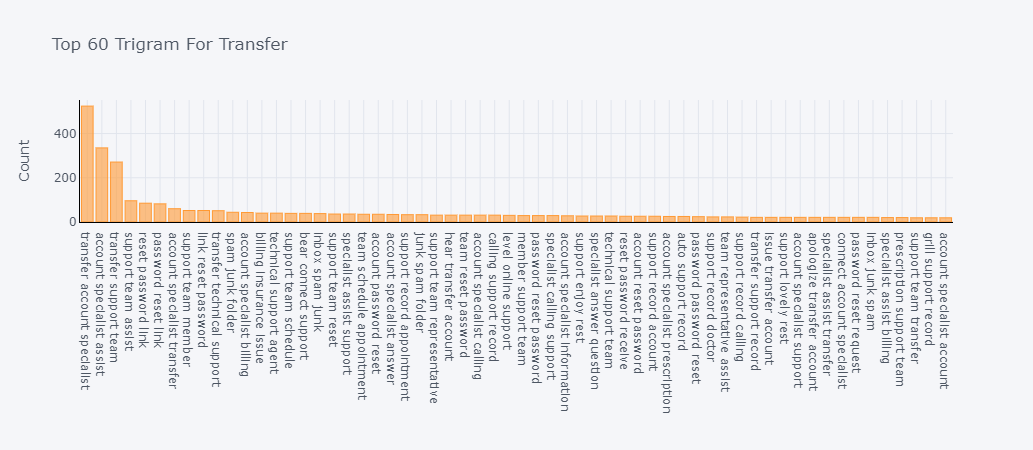

In [38]:
trigrcus

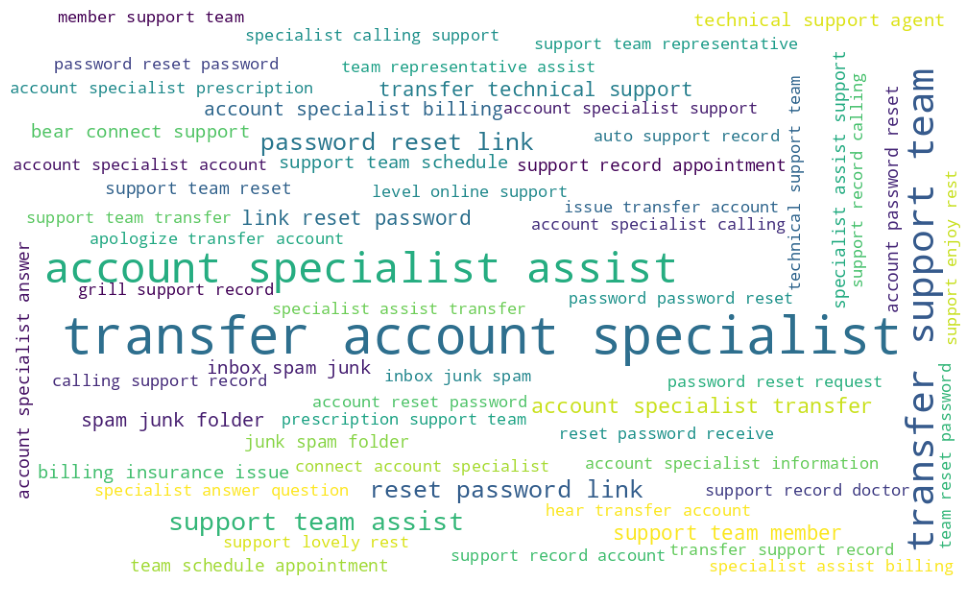

In [39]:
tria_data = dict(zip(trigram_df['Text'].tolist(), trigram_df['count'].tolist()))

wordcloud = WordCloud(
                width=1000,
                height=600,
                background_color="white",
                stopwords=stopwords,
                min_font_size=10,
                collocations=False
            ).generate_from_frequencies(tria_data)

# plot the WordCloud image
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [40]:
match_transfer("transfer account")

NameError: name 'match_transfer' is not defined

In [46]:
def match_transfer(x):
    
    if "transfer" == x.split()[0] or "transfer" == x.split()[1]:
        return "Match"
    
#     elif "connect" in x.split()[0] or "connect" in x.split()[0]:
#         return "Match"
    else:
        return "No Match"
    
    
def match_transfer_tri(x):
    
    if "transfer" == x.split()[0] or "transfer" == x.split()[1]  or "transfer" == x.split()[2]:
        return "Match"
    
#     elif "connect" in x.split()[0] or "connect" in x.split()[0]:
#         return "Match"
    else:
        return "No Match"

bigram_df["Transfer"] = bigram_df["Text"].apply(lambda x : match_transfer(x))
bi_transfer = bigram_df[bigram_df["Transfer"] == "No Match"].reset_index(drop=True)
print(bi_transfer.shape)


trigram_df["Transfer"] = trigram_df["Text"].apply(lambda x : match_transfer_tri(x))
tri_transfer = trigram_df[trigram_df["Transfer"] == "No Match"].reset_index(drop=True)
print(tri_transfer.shape)



(45, 3)
(50, 3)


In [42]:
bi_transfer.head(60)

,Text,count,Transfer
0,account specialist,1334,No Match
1,support record,652,No Match
2,support team,650,No Match
3,reset password,419,No Match
4,password reset,382,No Match
5,specialist assist,372,No Match
6,connect support,133,No Match
7,schedule appointment,118,No Match
8,password link,114,No Match
9,technical support,107,No Match


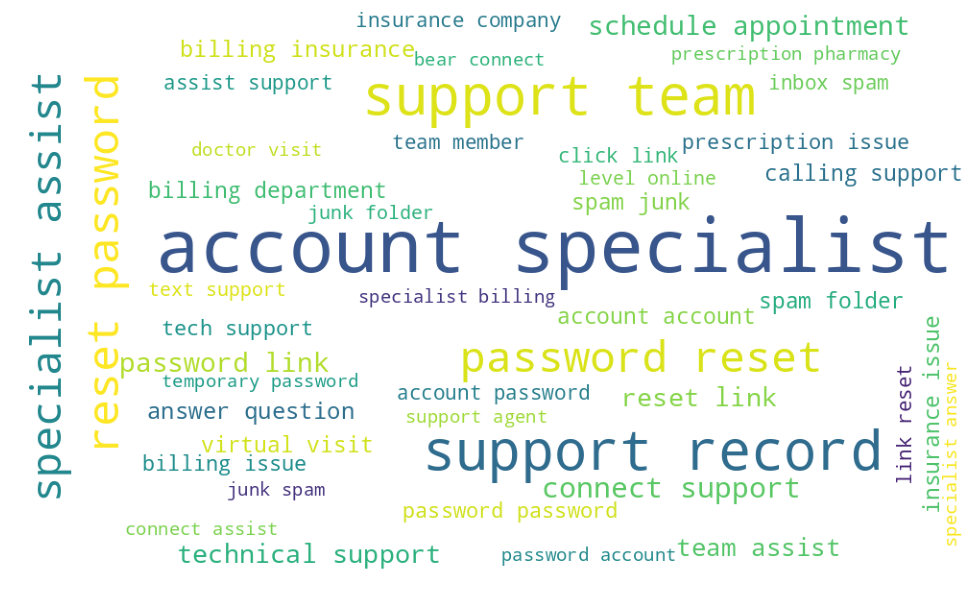

In [43]:
transfer_data = dict(zip(bi_transfer['Text'].tolist(), bi_transfer['count'].tolist()))

wordcloud = WordCloud(
                width=1000,
                height=600,
                background_color="white",
                stopwords=stopwords,
                min_font_size=10,
                collocations=False
            ).generate_from_frequencies(transfer_data)

# plot the WordCloud image
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [48]:
tri_transfer.head(60)

,Text,count,Transfer
0,account specialist assist,335,No Match
1,support team assist,96,No Match
2,reset password link,85,No Match
3,password reset link,82,No Match
4,support team member,52,No Match
5,link reset password,52,No Match
6,spam junk folder,44,No Match
7,account specialist billing,43,No Match
8,technical support agent,40,No Match
9,billing insurance issue,40,No Match


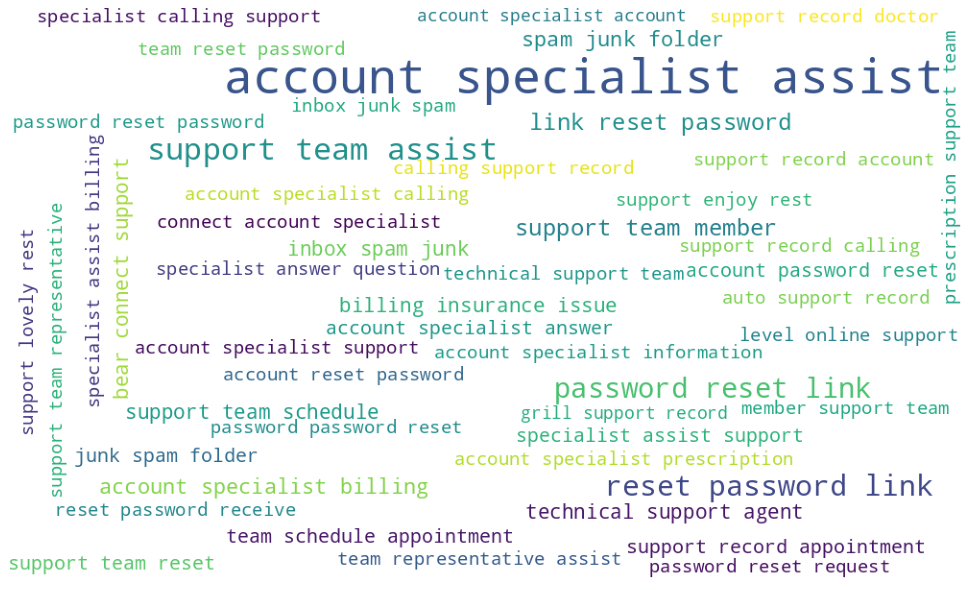

In [52]:
transfer_datatri = dict(zip(tri_transfer['Text'].tolist(), tri_transfer['count'].tolist()))

wordcloud = WordCloud(
                width=1000,
                height=600,
                background_color="white",
                stopwords=stopwords,
                min_font_size=10,
                collocations=False
            ).generate_from_frequencies(transfer_datatri)

# plot the WordCloud image
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [66]:
bigram_df.head(60)

,Text,count,Transfer
0,account specialist,1334,No Match
1,support record,652,No Match
2,support team,650,No Match
3,transfer account,554,Match
4,reset password,419,No Match
5,transfer support,413,Match
6,password reset,382,No Match
7,specialist assist,372,No Match
8,transfer prescription,135,Match
9,connect support,133,No Match


## Keyword Match

In [76]:
bi_words_list = bi_transfer["Text"].values.tolist()
bi_words_list

['account specialist',
 'support record',
 'support team',
 'reset password',
 'password reset',
 'specialist assist',
 'connect support',
 'schedule appointment',
 'password link',
 'technical support',
 'reset link',
 'team assist',
 'billing insurance',
 'answer question',
 'virtual visit',
 'spam junk',
 'spam folder',
 'billing department',
 'calling support',
 'insurance issue',
 'account account',
 'prescription issue',
 'tech support',
 'billing issue',
 'password password',
 'insurance company',
 'team member',
 'link reset',
 'inbox spam',
 'click link',
 'assist support',
 'account password',
 'text support',
 'junk folder',
 'level online',
 'support agent',
 'bear connect',
 'password account',
 'doctor visit',
 'connect assist',
 'temporary password',
 'specialist answer',
 'junk spam',
 'specialist billing',
 'prescription pharmacy']

In [68]:
def check(text):
    a = []
    for word in bi_words_list:
        if word.split()[0] in text.split() and word.split()[1] in text.split():
            a.append(word)
            
    if len(a) == 0:
        return "No Match"
    else:
        return a

In [69]:
df_sup["Bigram_keywords"] = df_sup["clean_text"].apply(lambda x : check(x))

In [70]:
df_sup.head()

,Session_id,redacted_transcript,sentiment_score,magnitude,speaker,start_timestamp_usec,sequence,clean_text,Bigram_keywords
0,AmWell Support.284.03K0167.03-15-2021-192355,"Thank you for calling American. Well, support...",0.0,12.9,Agent,1000000,153934,support record appointment information prescri...,"[support record, transfer account, transfer su..."
1,AmWell Support.52.0366KE7.03-14-2021-095426,"Thank you for calling American, will support o...",0.0,2.4,Agent,1000000,156575,support record confirm cover insurance informa...,[support record]
2,AmWell Support.69.03MTX4R.03-16-2021-104044,"Thank you for calling American. Well, support...",0.0,5.7,Agent,1000000,158552,support record login enrol system apologize in...,"[support record, support team, transfer suppor..."
3,AmWell Support.1031.01KMX5N.03-08-2021-023059,"Thank you for calling American. Well, support ...",0.0,6.5,Agent,1000000,162458,support record transfer technical support agen...,"[support record, transfer support, technical s..."
4,AmWell Support.104.00HDH38.01-13-2021-203809,Thank you for calling American Wild support. W...,0.0,12.9,Agent,1000000,162726,wild support record tonight copy receipt payme...,"[account specialist, support record, transfer ..."


In [71]:
df_sup.shape

(5456, 9)

In [72]:
final  = df_sup[df_sup["Bigram_keywords"]!="No Match"].reset_index(drop=True)
final.drop("clean_text", axis=1, inplace=True)

In [73]:
final.shape

(4355, 8)

In [74]:
final.head()

,Session_id,redacted_transcript,sentiment_score,magnitude,speaker,start_timestamp_usec,sequence,Bigram_keywords
0,AmWell Support.284.03K0167.03-15-2021-192355,"Thank you for calling American. Well, support...",0.0,12.9,Agent,1000000,153934,"[support record, transfer account, transfer su..."
1,AmWell Support.52.0366KE7.03-14-2021-095426,"Thank you for calling American, will support o...",0.0,2.4,Agent,1000000,156575,[support record]
2,AmWell Support.69.03MTX4R.03-16-2021-104044,"Thank you for calling American. Well, support...",0.0,5.7,Agent,1000000,158552,"[support record, support team, transfer suppor..."
3,AmWell Support.1031.01KMX5N.03-08-2021-023059,"Thank you for calling American. Well, support ...",0.0,6.5,Agent,1000000,162458,"[support record, transfer support, technical s..."
4,AmWell Support.104.00HDH38.01-13-2021-203809,Thank you for calling American Wild support. W...,0.0,12.9,Agent,1000000,162726,"[account specialist, support record, transfer ..."


In [75]:
final.to_csv("transfercall_bigramms_with_transferkey.csv", index=False)

## Get matching session id between transfer and thankyou

In [26]:
import pandas as pd
tr = pd.read_csv("transfercall_bigramms_with_transferkey.csv")

In [27]:
tr.head()

,Session_id,redacted_transcript,sentiment_score,magnitude,speaker,start_timestamp_usec,sequence,Bigram_keywords
0,AmWell Support.284.03K0167.03-15-2021-192355,"Thank you for calling American. Well, support...",0.0,12.9,Agent,1000000,153934,"['support record', 'transfer account', 'transf..."
1,AmWell Support.52.0366KE7.03-14-2021-095426,"Thank you for calling American, will support o...",0.0,2.4,Agent,1000000,156575,['support record']
2,AmWell Support.69.03MTX4R.03-16-2021-104044,"Thank you for calling American. Well, support...",0.0,5.7,Agent,1000000,158552,"['support record', 'support team', 'transfer s..."
3,AmWell Support.1031.01KMX5N.03-08-2021-023059,"Thank you for calling American. Well, support ...",0.0,6.5,Agent,1000000,162458,"['support record', 'transfer support', 'techni..."
4,AmWell Support.104.00HDH38.01-13-2021-203809,Thank you for calling American Wild support. W...,0.0,12.9,Agent,1000000,162726,"['account specialist', 'support record', 'tran..."


In [28]:
from google.cloud import bigquery

def read_cluster_data(query,project_id,data_type="STRING",**kwargs):
    """
    reading query data

    :type query: String
    :param query: Sql query for extracting data from big query

    :type project_id: String
    :param project_id: project id associated with big query
    """
    query_parameters=[]
    for key, value in kwargs.items():
        query_parameters.append(bigquery.ScalarQueryParameter(key, data_type, value))   
    client = bigquery.Client()
    job_config = bigquery.QueryJobConfig(query_parameters=query_parameters)
    df = client.query(query, job_config=job_config, project=project_id).to_dataframe()
    return df




ty = read_cluster_data(query ='SELECT * FROM `fivestar-ccai-recordings.amwell_ccai_fivestar_dev_us_ds.thankyou_call_bigrams_match`' ,project_id='fivestar-ccai-recordings')
print("Shape : ", ty.shape)
ty.head()

Shape :  (1718, 4)


,Session_id,speaker,transcript,Bigram_keywords
0,AmWell Support.315.02CN65T.03-10-2021-123617,Agent,Thank you for calling American Amwell support ...,"['support record', 'record support', 'virtual ..."
1,AmWell Support.25.035YXF3.02-25-2021-104333,Agent,"Thank you for calling American. Well, support ...","['support record', 'account specialist', 'tran..."
2,AmWell Support.343.01M5K5T.01-18-2021-151151,Agent,"Thank you for calling American. Well, support ...","['support record', 'connect support', 'record ..."
3,AmWell Support.227.03XWX2Q.03-01-2021-101028,Agent,"connect. Okay, so what I can do is I can go ah...","['support record', 'account specialist', 'conn..."
4,AmWell Support.104.00HDH38.01-13-2021-203809,Agent,Thank you for calling American Wild support. W...,"['support record', 'account specialist', 'conn..."


In [29]:
len(list(tr["Session_id"].unique()))

3739

In [30]:
len(list(ty["Session_id"].unique()))

1071

In [32]:
a = ((set(list(tr["Session_id"].unique())) & set(list(ty["Session_id"].unique()))))

In [33]:
a

{'AmWell Support.100.028PS6E.04-28-2021-171310',
 'AmWell Support.100.03HVR5V.05-04-2021-123631',
 'AmWell Support.100.03X45EG.03-17-2021-091637',
 'AmWell Support.101.00HHH39.04-21-2021-134859',
 'AmWell Support.101.03KY88L.03-16-2021-074017',
 'AmWell Support.1024.02WP34Q.03-12-2021-111230',
 'AmWell Support.1028.00MTDE.05-09-2021-160418',
 'AmWell Support.103.00RFW5T.04-06-2021-143601',
 'AmWell Support.103.00XF85T.04-07-2021-095352',
 'AmWell Support.103.03MDVDE.03-16-2021-101114',
 'AmWell Support.1031.0195S3Q.01-16-2021-164504',
 'AmWell Support.1031.03X0W2Q.03-17-2021-092356',
 'AmWell Support.1034.03TDH39.01-11-2021-184005',
 'AmWell Support.1039.00TV26.01-14-2021-204421',
 'AmWell Support.104.00HDH38.01-13-2021-203809',
 'AmWell Support.104.017TMDM.04-24-2021-125712',
 'AmWell Support.1048.02Z0Z2Q.03-12-2021-141440',
 'AmWell Support.105.00PNV77.03-03-2021-152227',
 'AmWell Support.105.0100P2Q.03-04-2021-151939',
 'AmWell Support.105.018MCDM.04-24-2021-153610',
 'AmWell Suppor

In [ ]:
common = pd.merge(tr, ty)

In [17]:
query = """select distinct a.session_id, b.speaker, trim(b.redacted_transcript) as transcript
from 
(select session_id, sum (cnt) total_cnt
from
(
SELECT session_id,ARRAY_LENGTH(REGEXP_EXTRACT_ALL(lower(redacted_transcript), "thank you for calling ")) cnt
from fivestar-ccai-recordings.fivestar_ccai_recordings.call_sentiment_support_8jul_offshore
where session_id like '%Support%' and speaker='Agent'
and lower(redacted_transcript) like '%thank you for calling american%'
)
group by session_id
having sum(cnt)>=2) a 
inner join 
fivestar-ccai-recordings.fivestar_ccai_recordings.call_sentiment_support_8jul_offshore b
on a.session_id=b.session_id
where speaker='Agent'
and lower(redacted_transcript) like '%thank you for calling american%' 
order by a.session_id"""

In [18]:
temp =  read_cluster_data(query =query ,project_id='fivestar-ccai-recordings')

In [19]:
temp.shape

(1757, 3)

In [22]:
temp.head()

,session_id,speaker,transcript
0,AmWell Support.100.0169Q5T.04-08-2021-094332,Agent,"Thank you for calling American Grill, support ..."
1,AmWell Support.100.0169Q5T.04-08-2021-094332,Agent,"me in regards to that your medication. So now,..."
2,AmWell Support.100.028PS6E.04-28-2021-171310,Agent,"Thank you for calling American. Well, support ..."
3,AmWell Support.100.03HVR5V.05-04-2021-123631,Agent,"Thank you for calling American. Well, support ..."
4,AmWell Support.100.03KY541.03-16-2021-073915,Agent,"Thank you for calling American. Well, support ..."


In [23]:
temp["session_id"].nunique()

1078

## Key word match only for transfer and connect 

In [98]:
bi_transfer.head()

,Text,count,Transfer
0,transfer account,554,Match
1,transfer support,413,Match
2,transfer prescription,135,Match
3,connect support,133,Match
4,transfer technical,67,Match


In [99]:
bi_words_tf = bi_transfer["Text"].values.tolist()

def check_tf(text):
    a = []
    for word in bi_words_tf:
        if word.split()[0] in text.split() and word.split()[1] in text.split():
            a.append(word)
            
    if len(a) == 0:
        return "No Match"
    else:
        return a
    
df_sup["Transfer"] = df_sup["clean_text"].apply(lambda x : check_tf(x))

final2  = df_sup[df_sup["Transfer"]!="No Match"].reset_index(drop=True)
final2.drop("clean_text", axis=1, inplace=True)
final2.shape

(2305, 9)

In [77]:
final2.head()

NameError: name 'final2' is not defined

In [106]:
list(final2["Session_id"].iloc[-11:])

['AmWell Support.1463.00VCR33.03-04-2021-104222',
 'AmWell Support.1490.01TVLCZ.03-08-2021-155139',
 'AmWell Support.909.00J2S5T.01-14-2021-074411',
 'AmWell Support.1451.03LSS4Q.04-18-2021-121354',
 'AmWell Support.1174.01WLJ2K.04-11-2021-164328',
 'AmWell Support.2004.038DN44.06-23-2021-164016 2833f436-29e6-4da7-b1d2-60243896e147',
 'AmWell Support.1742.003X44Q.01-12-2021-163802',
 'AmWell Support.2201.01K2V8B.03-07-2021-183250',
 'AmWell Support.2311.00CS54Q.05-07-2021-131100',
 'AmWell Support.2311.00CS54Q.05-07-2021-131100',
 'AmWell Support.4399.028G78C.05-16-2021-155847']

### Push result to bq

In [86]:
# # drop clean text colum and push to bq
# cus.drop("clean_text",axis=1,inplace=True)
# ag.drop("clean_text",axis=1,inplace=True)

In [62]:
final.to_gbq("amwell_ccai_fivestar_dev_us_ds.Transfer_call_bigrams_match",
                                    'fivestar-ccai-recordings',
                                    chunksize= 10000,
                                    if_exists='replace'
                                    )

1it [00:03,  3.85s/it]


In [97]:
# ag.to_gbq("amwell_ccai_fivestar_dev_us_ds.amwell_dev_concierge_bigram_second_agent_uttrences",
#                                     'fivestar-ccai-recordings',
#                                     chunksize= 10000,
#                                     if_exists='replace'
#                                     )

### big query table name

## Excel sheet 

https://docs.google.com/spreadsheets/d/1zza3W7s1GYF8095wD_DM8R5s74ekQDEU9pRwKgAe1AA/edit#gid=495616311

### END 26/07/2021 